In [1]:
!pip install tensorflow==2.16.1 opencv-python matplotlib

In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer, Conv2D, MaxPooling2D, Flatten
import tensorflow as tf

In [4]:
#to avoid the gpu error by setting gpu memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
print("Using CPU:", tf.config.list_physical_devices('CPU'))

Using CPU: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [13]:
POS_PATH= os.path.join('data','positive')
NEG_PATH= os.path.join('data','negative')
ANC_PATH= os.path.join('data','anchor')

In [14]:
#create directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [30]:

for directory in os.listdir('data/negative/lfw'):
    for file in os.listdir(os.path.join('data/negative/lfw', directory)):
        EX_PATH=os.path.join('data/negative/lfw', directory,file)
        NEW_PATH=os.path.join(NEG_PATH, file)
        os.replace(EX_PATH,NEW_PATH)

In [43]:
# Import uuid library to generate unique image names
import uuid

In [44]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\4a8ecfa5-056b-11f0-a036-0245e2b35d47.jpg'

In [47]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

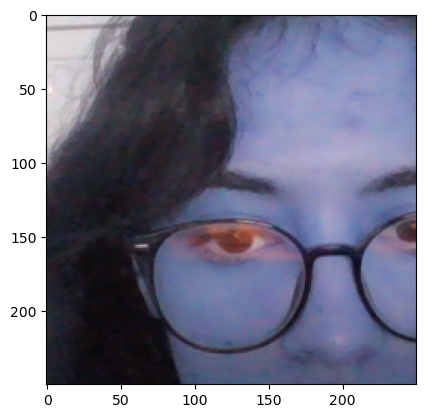

In [41]:
frame[:250,:250, :].shape
plt.imshow(frame[120:120+250,200:450, :])


In [51]:
anchor = tf.data.Dataset.list_files(ANC_PATH+ r'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+ r'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+ r'\*.jpg').take(300)

In [55]:
dir_test = anchor.as_numpy_iterator()

In [56]:
print(dir_test.next())

b'data\\anchor\\1dcea980-056c-11f0-a7b7-0245e2b35d47.jpg'


In [57]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [58]:
img = preprocess('data\\anchor\\1dcea980-056c-11f0-a7b7-0245e2b35d47.jpg')

In [62]:
img.numpy().max() 

0.75980395

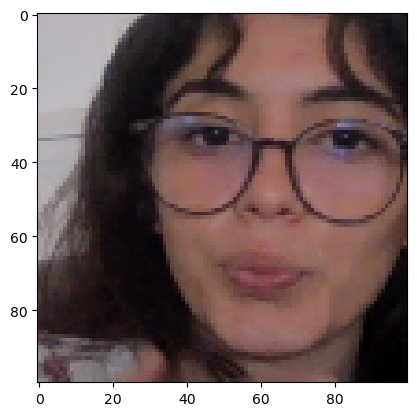

In [63]:
plt.imshow(img)

NameError: name 'dataset' is not defined